In [28]:
import datetime
import typing
import enum

import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
%matplotlib inline
#%matplotlib notebook

plt.rcParams["figure.figsize"] = 12, 8
plt.rcParams[  "font.size"   ] = 15

In [71]:
class LineType(enum.Enum):
    Voltage = 0
    Current = 1
    Spark   = 2
    Unknown = -1


class SCdata(typing.NamedTuple):
    datetime : np.ndarray
    voltage  : np.ndarray
    current  : np.ndarray
    sparks   : np.ndarray
    v_mean   : np.ndarray
    i_mean   : np.ndarray
    v_std    : np.ndarray
    i_std    : np.ndarray


def read_datetime(line):
    date, time, _ = line.split(" ")[0].split("\t")
    day, month, year     = date.split("/")
    hour, minute, second = time.split(":")
    return datetime.datetime(*map(int, (year, month, day, hour, minute, second)))


def read_value(line):
    value = line.split(" ")[-2].replace(",", ".")
    return float(value)


def classify_line(line):
    if   ("VOLTAGE"         in line and
          "RESTORED"    not in line and
          "RAMP"        not in line and
          "SET"         not in line    ):
        return LineType.Voltage
    elif ("CURRENT"         in line and
          "SET"         not in line    ):
        return LineType.Current
    elif "SPARK DETECTED" in line       :
        return LineType.Spark
    else:
        return LineType.Unknown

    
def hhv_data_reader(*filenames, window_size=100):
    datetimes = []
    voltages  = []
    currents  = []
    sparks    = []
    state     = "I"
    for filename in filenames:
        with open(filename) as file:
            data = ""
            while "CURRENT" not in data:
                data = file.readline()

            for i, line in enumerate(file):
                if line == "\n": continue
                
                line_type = classify_line(line)

                if  line_type is LineType.Voltage:
                    if state != "I": raise RuntimeError(f"Invalid state in line {i}: {state}")
                    state   = "V"
                    time    = read_datetime(line)
                    voltage = read_value   (line)

                elif line_type is LineType.Current:
                    if state != "V": raise RuntimeError(f"Invalid state in line {i}: {state}")
                    state = "I"

                    current = read_value(line)

                    datetimes.append(time)
                    voltages .append(voltage)
                    currents .append(current)

                elif line_type is LineType.Spark:
                    time = read_datetime(line)
                    sparks.append(time)

                else:
                    pass
#                    print("Unexpected data in line {}: {}".format(i, repr(line)))
#                    raise RuntimeError("Unexpected data in line {}: {}".format(i, repr(line)))

    assert len(datetimes) == len(voltages) == len(currents)

    v_rolling = pd.Series(voltages).rolling(window_size)
    i_rolling = pd.Series(currents).rolling(window_size)
    v_mean    = v_rolling.mean()
    i_mean    = i_rolling.mean()
    v_std     = v_rolling.std ()
    i_std     = i_rolling.std ()

    return SCdata(*map(np.array, (datetimes, voltages, currents, sparks, v_mean, i_mean, v_std, i_std)))

In [132]:
def time_before_spark(data):
    datetimes, _, _, sparks, *_ = data
    datetimes_before_spark = np.full(datetimes.size, np.nan, dtype=float)
    sparks = np.concatenate(([datetimes[0]], sparks))
    for i in range(1, sparks.size):
        where_before_spark     = (datetimes > sparks[i-1]) & (datetimes < sparks[i])
        before_spark           = datetimes[where_before_spark] - sparks[i]
        datetimes_before_spark[where_before_spark] = list(map(datetime.timedelta.total_seconds, before_spark))
    return datetimes_before_spark

In [133]:
tbs = time_before_spark(data)

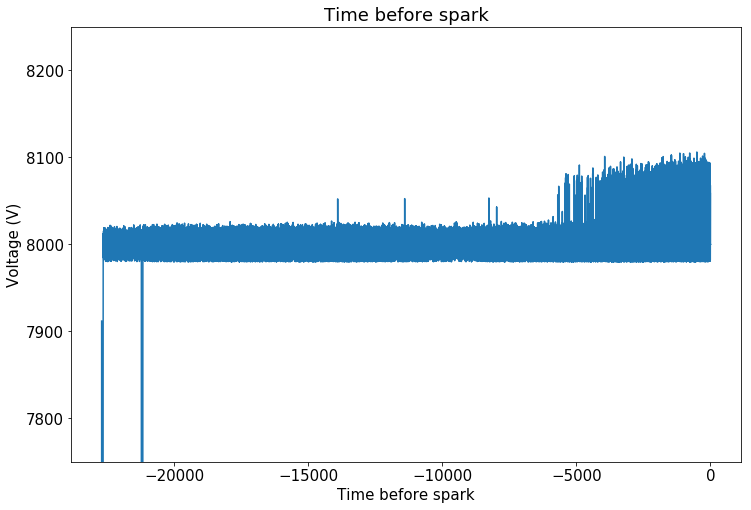

In [136]:
plt.plot(tbs, -data.voltage)
plt.ylim(7750, 8250)

plt.xlabel("Time before spark")
plt.ylabel("Voltage (V)")
plt.title ("Time before spark")

In [75]:
filename = "/Users/Gonzalo/github/NEXTdata/voltages/FUG02_GATE_Report_2018-02-27.txt"
data     = hhv_data_reader(filename)

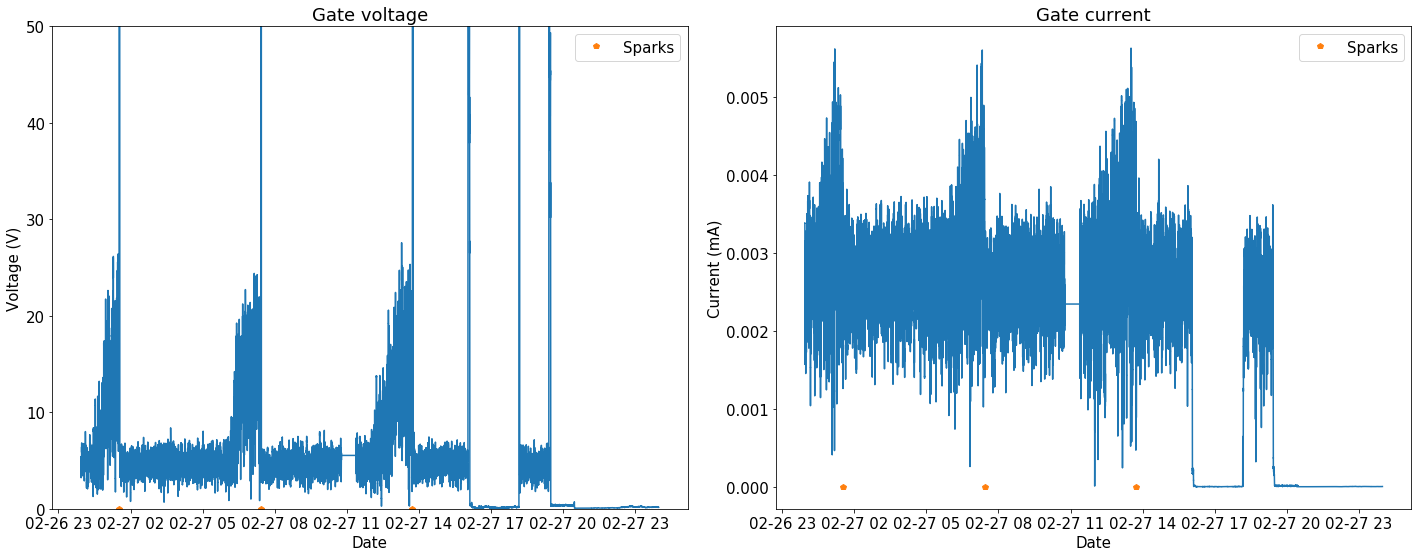

In [156]:
plt.figure(figsize=(20, 8))

i = 1
plt.subplot(1, 2, i); i +=1
plt.plot(data.datetime, data.v_std)
plt.plot(data.sparks, np.zeros(data.sparks.size), "p", label="Sparks")
plt.ylim(0, 50)
plt.xlabel("Date");plt.ylabel("Voltage (V)");plt.title("Gate voltage")
plt.legend()

plt.subplot(1, 2, i); i +=1
plt.plot(data.datetime,  data.i_std)
plt.plot(data.sparks, np.zeros(data.sparks.size), "p", label="Sparks")
plt.xlabel("Date");plt.ylabel("Current (mA)");plt.title("Gate current")
plt.legend()

plt.tight_layout()

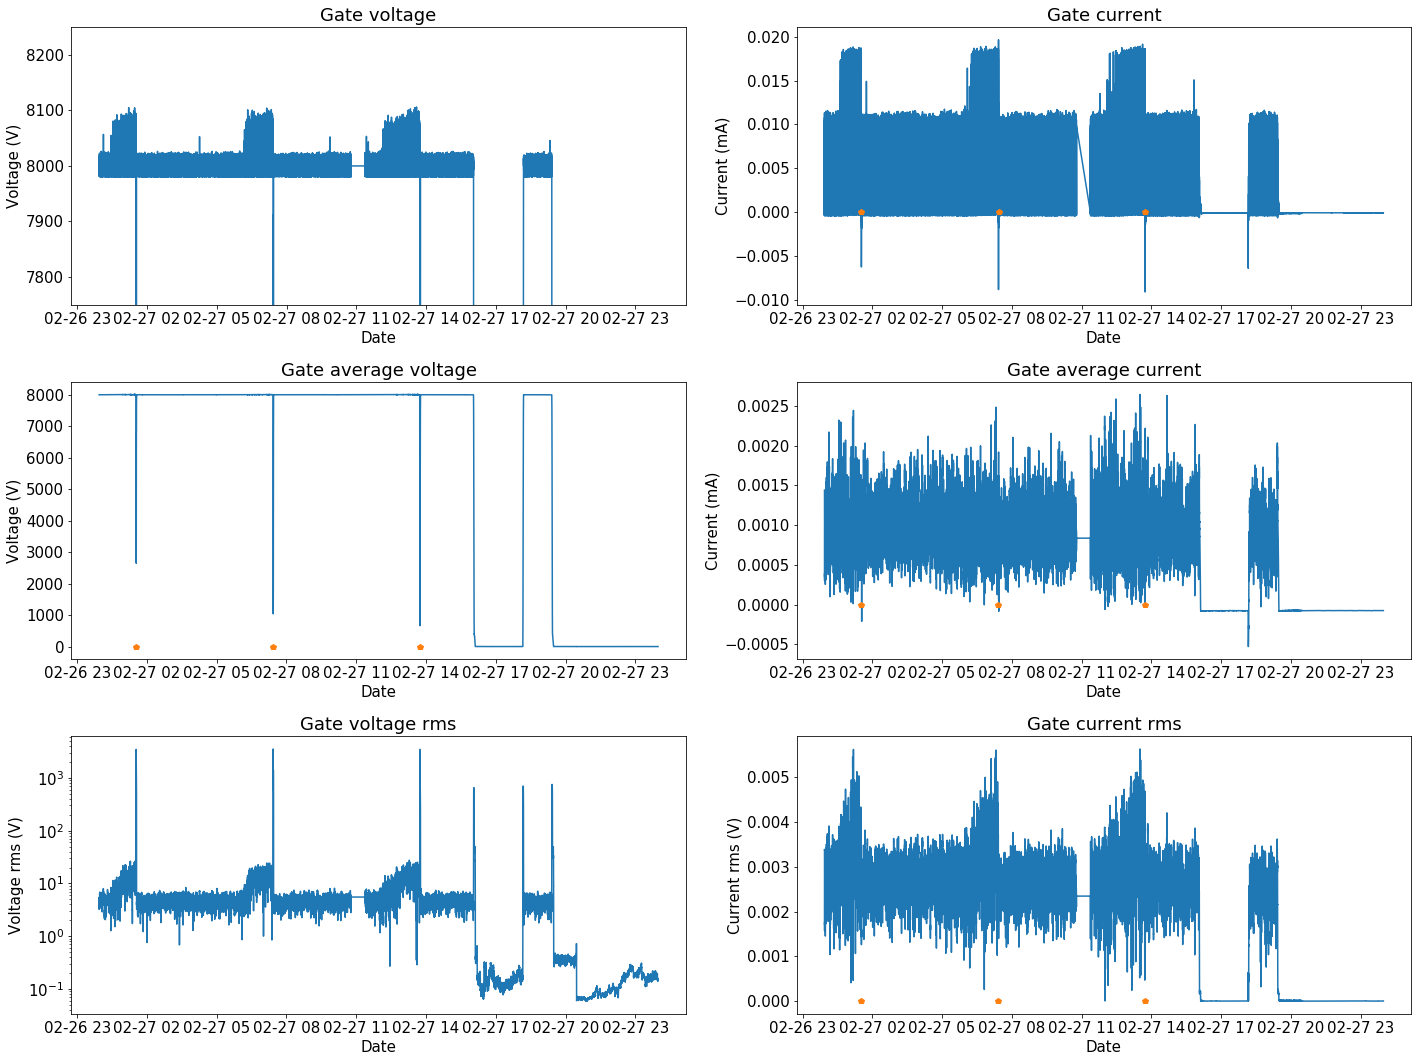

In [92]:
plt.figure(figsize=(20, 15))

i = 1
plt.subplot(3, 2, i); i +=1
plt.plot(data.datetime, -data.voltage)
plt.plot(data.sparks, np.zeros(data.sparks.size), "p")
plt.ylim(7750, 8250)
plt.xlabel("Date");plt.ylabel("Voltage (V)");plt.title("Gate voltage")

plt.subplot(3, 2, i); i +=1
plt.plot(data.datetime,  data.current)
plt.plot(data.sparks, np.zeros(data.sparks.size), "p")
plt.xlabel("Date");plt.ylabel("Current (mA)");plt.title("Gate current")

plt.subplot(3, 2, i); i +=1
plt.plot(data.datetime, -data.v_mean)
plt.plot(data.sparks, np.zeros(data.sparks.size), "p")
plt.xlabel("Date");plt.ylabel("Voltage (V)");plt.title("Gate average voltage")

plt.subplot(3, 2, i); i +=1
plt.plot(data.datetime,  data.i_mean)
plt.plot(data.sparks, np.zeros(data.sparks.size), "p")
plt.xlabel("Date");plt.ylabel("Current (mA)");plt.title("Gate average current")

plt.subplot(3, 2, i); i +=1
plt.plot(data.datetime,  data.v_std)
plt.plot(data.sparks, np.zeros(data.sparks.size), "p")
plt.yscale("log")
plt.xlabel("Date");plt.ylabel("Voltage rms (V)");plt.title("Gate voltage rms")

plt.subplot(3, 2, i); i +=1
plt.plot(data.datetime,  data.i_std)
plt.plot(data.sparks, np.zeros(data.sparks.size), "p")
plt.xlabel("Date");plt.ylabel("Current rms (V)");plt.title("Gate current rms")

plt.tight_layout()

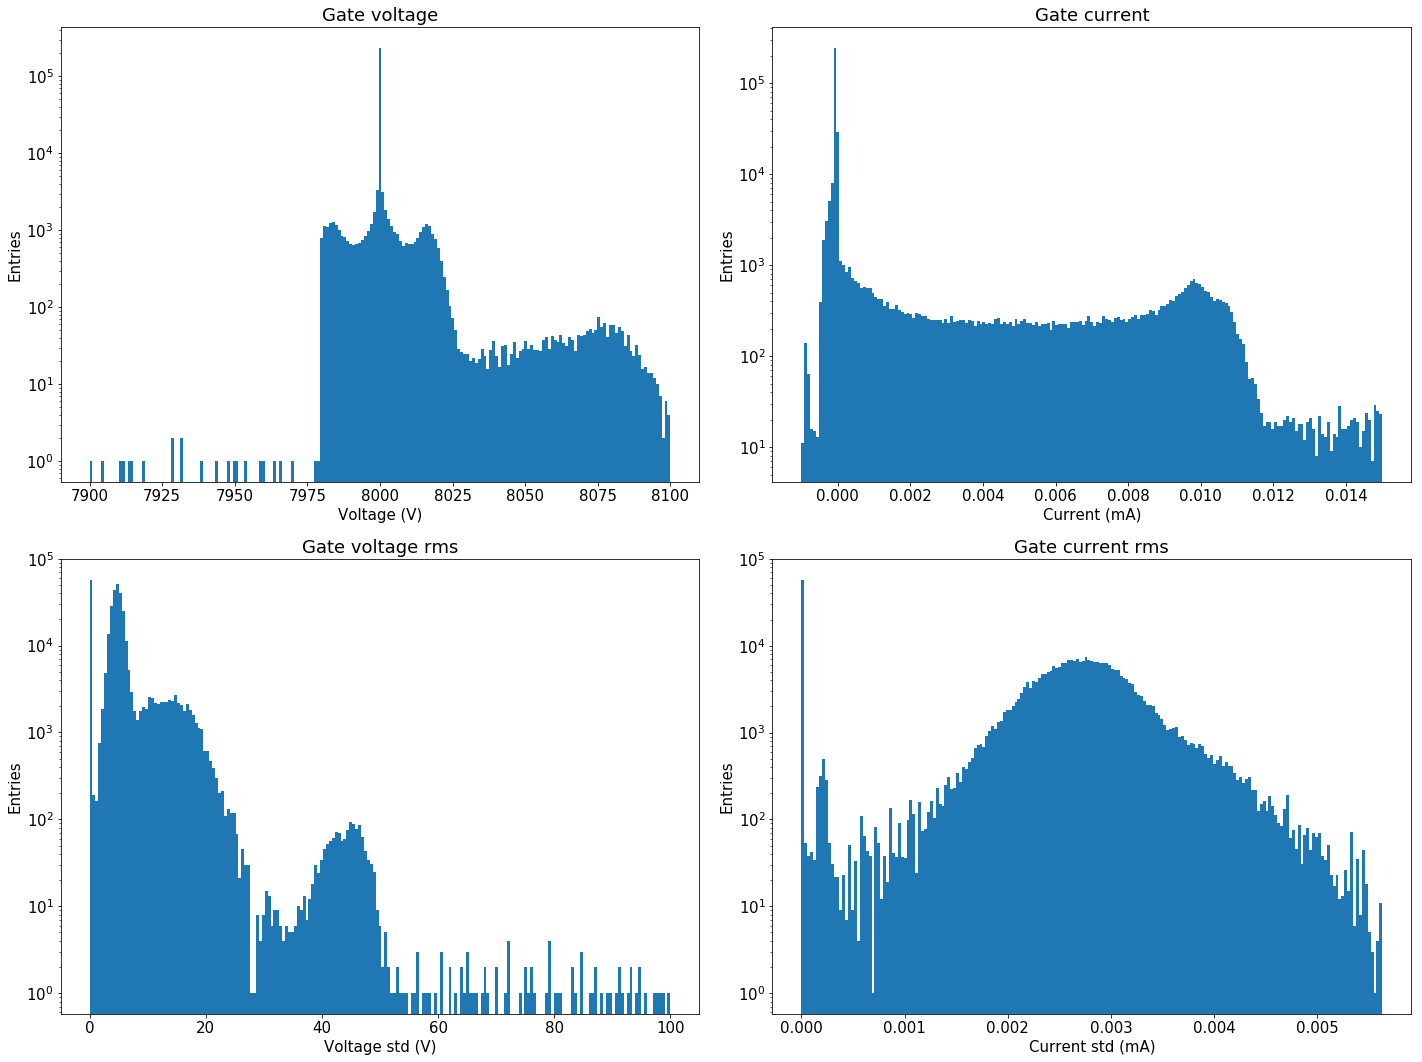

In [137]:
plt.figure(figsize=(20, 15))

def plt_hist(data, x_min=None, x_max=None, nbins=200):
    selection = ~np.isnan(data) & np.isfinite(data)
    selected_data = data[selection]
    if x_min is None: x_min = selected_data.min()
    if x_max is None: x_max = selected_data.max()
    plt.hist(selected_data, np.linspace(x_min, x_max, nbins))

    
i = 1
plt.subplot(2, 2, i); i +=1
plt_hist(-data.voltage, 7900, 8100)
plt.yscale("log")
plt.xlabel("Voltage (V)");plt.ylabel("Entries");plt.title("Gate voltage")

plt.subplot(2, 2, i); i +=1
plt_hist( data.current, -1e-3, 15e-3)
plt.yscale("log")
plt.xlabel("Current (mA)");plt.ylabel("Entries");plt.title("Gate current")

plt.subplot(2, 2, i); i +=1
plt_hist( data.v_std, 0, 100)
plt.yscale("log")
plt.xlabel("Voltage std (V)");plt.ylabel("Entries");plt.title("Gate voltage rms")

plt.subplot(2, 2, i); i +=1
plt_hist( data.i_std, 0, )
plt.yscale("log")
plt.xlabel("Current std (mA)");plt.ylabel("Entries");plt.title("Gate current rms")

plt.tight_layout()

In [ ]:
plt.plot(data.datetimes, currents)
plt.plot(data.spark   s, np.full(sparks.size, np.max(currents)), "p")

In [13]:
window_size = 100

v_mean = pd.rolling_mean(voltages, window_size)
i_mean = pd.rolling_mean(currents, window_size)
v_std  = pd.rolling_std (voltages, window_size)
i_std  = pd.rolling_std (voltages, window_size)

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  after removing the cwd from sys.path.
/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  """
/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  


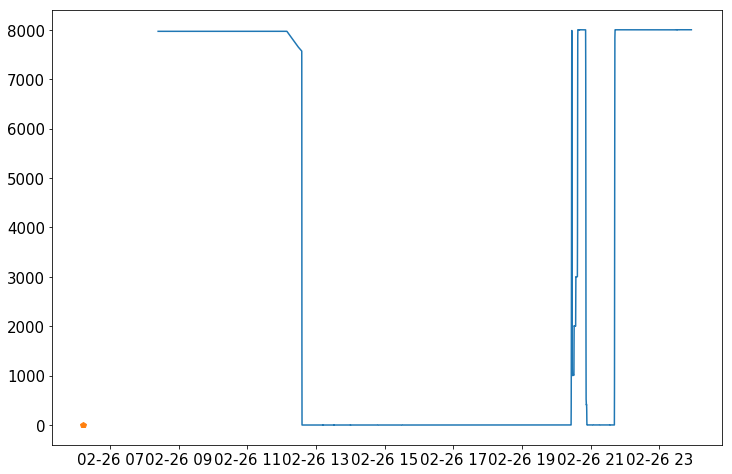

In [14]:
plt.plot(datetimes, -v_mean)
plt.plot(sparks, np.ones(sparks.size), "p")

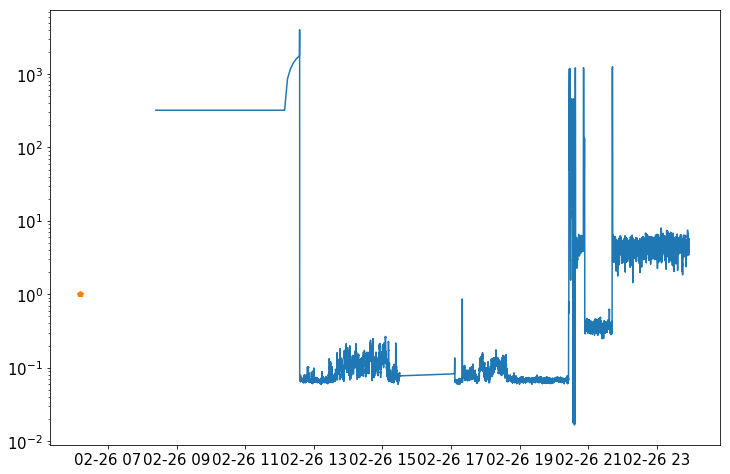

In [15]:
plt.plot(datetimes, v_std)
plt.plot(sparks, np.ones(sparks.size), "p")
plt.yscale("log")